In [35]:
import meanreversion as mr
import numpy as np
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed

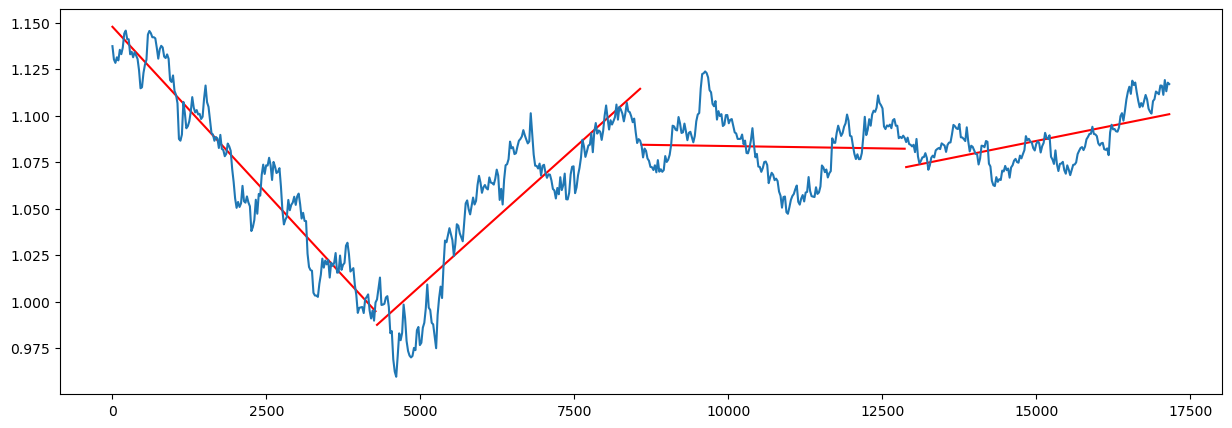

In [36]:
data = mr.download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')
mesh = np.linspace(0, len(data), 5)

#data = mr.load_asset("data/DAX_M15_202005242300_202411131015.csv")
#mesh = np.array([0,int(len(data)/4), int(len(data)/2), int(len(data))])

fig = plt.figure(figsize=(15,5))
ax = plt.subplot()
slices = mr.removeTrend(data, mesh, ax)
ax.plot(data.index, data["Close"])
plt.show()

Periods:  1.044943820224719
Amplitudes:  0.32160089075301096


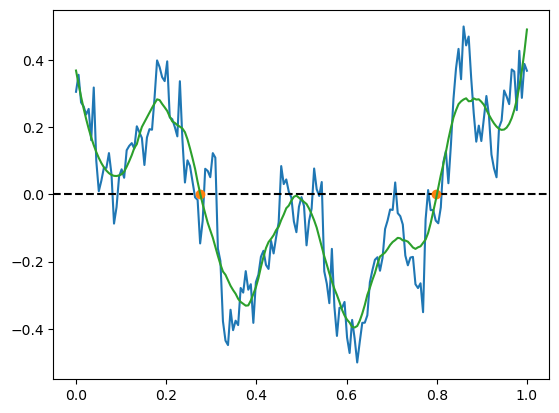

In [89]:
# TODO: extrapolate functions to meanreversion.py

x = slices[3].to_numpy()
t = slices[3].index.to_numpy()

t = (t - t.min()) / (t.max()-t.min())   # Normalize time values to [0, 1]
x = x / (x.max()-x.min())   # Normalize price values to [0, 1]

from scipy.signal import savgol_filter, find_peaks
x_filtered = savgol_filter(x, window_length=len(x)//5, polyorder=3)


periods = mr.find_periods(t, x_filtered)
peaks = mr.find_amplitudes(t, x_filtered)

print("Periods: ", np.mean(periods))
print("Amplitudes: ", np.mean(peaks))

plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(mr.find_zeros(t, x_filtered), np.zeros(len(mr.find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.show()


In [90]:
from scipy.fftpack import fft, fftfreq, ifft


period_fft, phase_fft = mr.find_period_fft(t, x_filtered)
print("Period via FFT: ", period_fft)
print("Phase via FFT: ", phase_fft)

Period via FFT:  0.37710674157303364
Phase via FFT:  0.11334424981509923


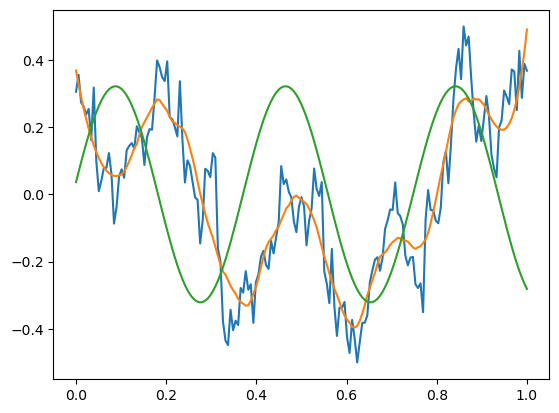

In [91]:
plt.plot(t, x)
plt.plot(t, x_filtered)
plt.plot(t, peaks.mean()*np.sin(2*np.pi*t/period_fft + phase_fft))
plt.show()

## Maximum Likelihood estimation to find volatility
As probability, we aproximate the propagator with a gaussian (we should solve the Fokker-Planck equation)

$$dx(t)=f(x,t,\boldsymbol{\theta})dt+g(x,t,\boldsymbol{\theta})dB(t)$$

$$p_{\boldsymbol{\theta}}(x,t|y)\simeq\mathcal{N}_y(x+f(x,t,\boldsymbol{\theta})t, tg^2(x,t,\boldsymbol{\theta}))$$

$$\mathcal{L}(x,t,\boldsymbol{\theta})=\prod p_{\boldsymbol{\theta}}(x,t|y)$$

$$\boldsymbol{\theta}=\arg\max_{\boldsymbol{\theta}}\mathcal{L}(x,t,\boldsymbol{\theta})$$
As minimization in quite unstable, we use the previously founded phase $\varphi$, amplitude $A$ and frequency $\omega=2\pi/T$ as exact values. We use the Ornstein Uhlenbeck process as SDE and the following functions as model:
$$f(x,t,\boldsymbol{\theta})=\theta(A\sin(\omega t+\varphi)-x)$$
$$f(x,t,\boldsymbol{\theta})=\sigma$$
The parameters to be estimated are only $\boldsymbol{\theta}=\{\theta, \sigma\}$ where $\theta$ give the Ornstein Uhlenbeck "speed" and $\sigma$ give information about volatility of the price. As mean reversion metric we can choose the ratio between amplitude and volatility: if the amplitude of the oscillation is bigger than the random fluctuation, then we have a mean reversion dynamic.
$$MRI=2^{-\sigma/A}$$
if $MRI$ (Mean Reversion Index) is significally close to 1, then is more likely that we have mean reversion.

In [92]:
# to simplify the minimization process we assume that the period and amplitude are known from the previous calculation
amplitude = np.mean(peaks)
frequency = 2*np.pi / ((np.mean(periods) + period_fft)/2)
print("Amplitude: ", amplitude)
print("Frequiency: ", frequency)

# Define the SDE
def f(t, x, params):
    omega, phi, theta, _ = params
    A = amplitude
    return theta * (A*np.sin(omega*t + phi) - x) + A*omega*np.cos(omega*t + phi)

def g(x, params):
    return params[3]

from scipy.optimize import minimize
bounds = ((0, None), (-2*np.pi, 2*np.pi), (1e-3, None), (0.0, None))  # bounds for the parameters
guess = [frequency, phase_fft, 1.0, 1.0]
print("\nInitial guess: ", guess)

res = minimize(mr.log_likelihood, guess, args=(x_filtered, t, f, g), method='L-BFGS-B', options={'disp': False, 'ftol': 1e-6}, bounds=bounds)
omega_val, phi_val, theta_val, sigma_val = res.get('x')

print("Optimal parameters: ", res.get('x'))
print(f"\nVolatility: {sigma_val:.4}")
print(f"MRI: {2**(-sigma_val/amplitude):.4}")
print(f"Ornstein-Uhlenbeckrn half-life {np.log(2)/theta_val:.4}")

Amplitude:  0.32160089075301096
Frequiency:  8.836795928319736

Initial guess:  [8.836795928319736, 0.11334424981509923, 1.0, 1.0]
Optimal parameters:  [6.84706562 1.54414844 0.43860891 0.27417162]

Volatility: 0.2742
MRI: 0.5538
Ornstein-Uhlenbeckrn half-life 1.58


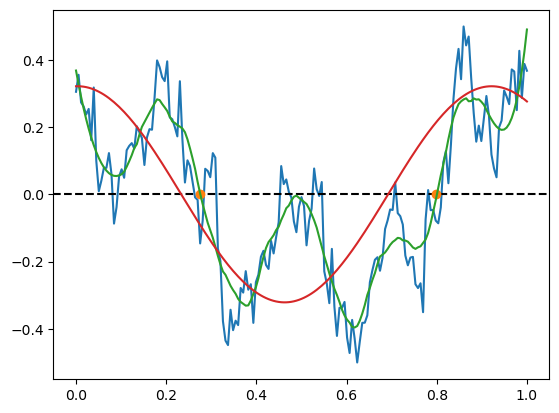

In [93]:
plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(mr.find_zeros(t, x_filtered), np.zeros(len(mr.find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val))
plt.show()

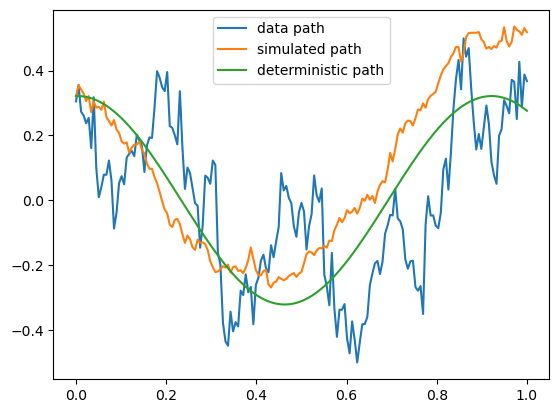

In [94]:
mu = lambda t, x : theta_val * (amplitude*np.sin(omega_val*t + phi_val) - x) + amplitude*omega_val*np.cos(omega_val*t + phi_val)
sigma = lambda t, x : sigma_val

np.random.seed(1)

X = mr.SDE_solver(x0=amplitude*np.sin(phi_val), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val), label='deterministic path')
plt.legend()
plt.show()

## Autoregressive model
An autoregressive model $AR(1)$ can be expressed as the discrete process $X_{k+1}=c+\varphi X_k+\varepsilon_k$. From the integration of the time-continuous stochastic differential equation for an Ornstein Uhlenbeck process we can express the parameters of the $AR(1)$ starting from the discretization $X_k=x(k\Delta t)$:
$$x(t)=x(0)e^{-\theta t}+\mu(1-e^{-\theta t})+\sigma\int_0^t e^{-\theta (t-s)}dB_s$$
From this we find that:
$$\varphi=e^{-\theta\Delta t}\hspace{0.5cm}c=\mu(1-e^{-\theta\Delta t})\hspace{0.5cm}\varepsilon_k\sim\mathcal{N}\left(0,\frac{1}{2\theta}\sigma^2(1-e^{-2\theta \Delta t})\right)$$
Using the $AR(1)$ model we find $\varphi$ and the variance $\sigma_\varepsilon$ of $\varepsilon_k$ and therefore we can estimate both $\theta$ and $\sigma$:
$$\theta=-\frac{\log{\varphi}}{\Delta t}\hspace{1cm}\sigma=\sigma_{\varepsilon}\sqrt{\frac{2\log{\varphi}}{\Delta{t}(\varphi^2-1)}}$$


In [95]:
from statsmodels.tsa.arima.model import ARIMA

In [96]:
AR_model = ARIMA(x, order=(1,0,0), trend='n')
res = AR_model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 189.986
Date:                Wed, 12 Feb 2025   AIC                           -375.971
Time:                        00:35:08   BIC                           -369.596
Sample:                             0   HQIC                          -373.386
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9411      0.026     36.304      0.000       0.890       0.992
sigma2         0.0069      0.001     10.874      0.000       0.006       0.008
Ljung-Box (L1) (Q):                   0.77   Jarque-

In [97]:
AR_phi = res.params[0]
AR_sigma = res.params[1]

dt = t[1] - t[0]
theta_AR = -np.log(AR_phi)/dt
sigma_AR = np.sqrt(AR_sigma*(2*theta_AR/(1-AR_phi**2)))

print(f"AR(1) parameters: {AR_phi:.4}, {AR_sigma:.4}")
print(f"Ornstein-Uhlenbeck half-life: {np.log(2)/theta_AR:.4}")
print(f"Volatility: {sigma_AR:.4}")

print(f"volatility-amplitude ratio: {sigma_AR/amplitude:.4}")


AR(1) parameters: 0.9411, 0.006923
Ornstein-Uhlenbeck half-life: 0.06412
Volatility: 1.144
volatility-amplitude ratio: 3.557


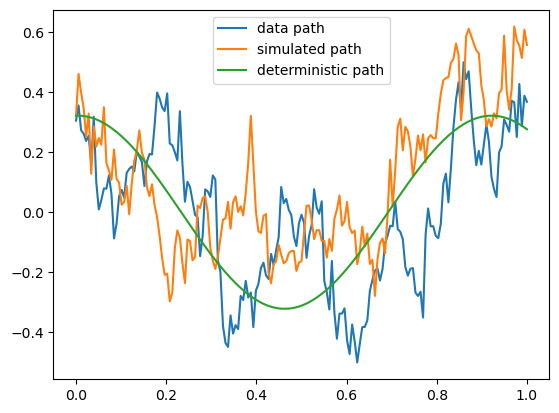

In [98]:
mu = lambda t, x : theta_AR * (amplitude*np.sin(omega_val*t + phi_val) - x) + amplitude*omega_val*np.cos(omega_val*t + phi_val)
sigma = lambda t, x : sigma_AR

np.random.seed(1)

X = mr.SDE_solver(x0=amplitude*np.sin(phi_val), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val), label='deterministic path')
plt.legend()
plt.show()

## Rolling mean reversion metric

In [ ]:
def amplitude(x : np.array) -> float:
    '''Calculate the amplitude of a time series
    Args:
        x : np.array : time series
    Returns:
        float : amplitude
    '''
    t =  np.linspace(0, 1, len(x))
    slope, intercept = np.polyfit(t, x, 1)
    x = x - (slope*t + intercept)
    x = x / (x.max()-x.min())
    x_filtered = savgol_filter(x, window_length=len(x)//5, polyorder=3)
    amplitude = np.mean(mr.find_amplitudes(t, x_filtered))
    return amplitude

def volatility(x : np.array) -> float:
    '''Calculate the volatility of a time series usign AR(1) model
    Args:
        x : np.array : time series
    Returns:
        float : volatility
    '''
    t =  np.linspace(0, 1, len(x))
    slope, intercept = np.polyfit(t, x, 1)
    x = x - (slope*t + intercept)
    x = x / (x.max()-x.min())
    AR_model = ARIMA(x, order=(1,0,0), trend='n')
    res = AR_model.fit()
    AR_phi = res.arparams[0]
    AR_sigma = res.params[-1]

    if AR_phi <= 0 or AR_phi >= 1:
        return np.nan
    sigma_AR = np.sqrt(AR_sigma * (2 * theta_AR / (1 - AR_phi**2)))
    
    return sigma_AR

def mean_reverting_index(x : np.array) -> float:
    '''Calculate the mean-reverting index of a time series
    Args:
        x : np.array : time series
    Returns:
        float : mean-reverting index from 0 to 1
    '''
    return 2**(-volatility(x)/amplitude(x))


#import pandas as pd

#data = mr.download_asset("EURUSD=X", start='2022-01-01',end='2025-01-01')
#df = pd.DataFrame({'t' : data["AbsTime"], 'x' : data["Close"]})
#df = df.set_index('t')

#df["volatility"] = df['x'].rolling(window=180).apply(rolling_volatility, raw=False)
#df["amplitude"] = df['x'].rolling(window=180).apply(rolling_amplitude, raw=False)

In [124]:
data = mr.download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')
mesh = np.linspace(0, len(data), 5)

price = data['Close'].to_numpy()
x = price[int(mesh[3]):int(mesh[4])]

print(amplitude(x))
print(volatility(x))
print(mean_reverting_index(x))

[*********************100%***********************]  1 of 1 completed

0.32160089075301207
1.1439933347771736
0.08495346766647227
